In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import pickle
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

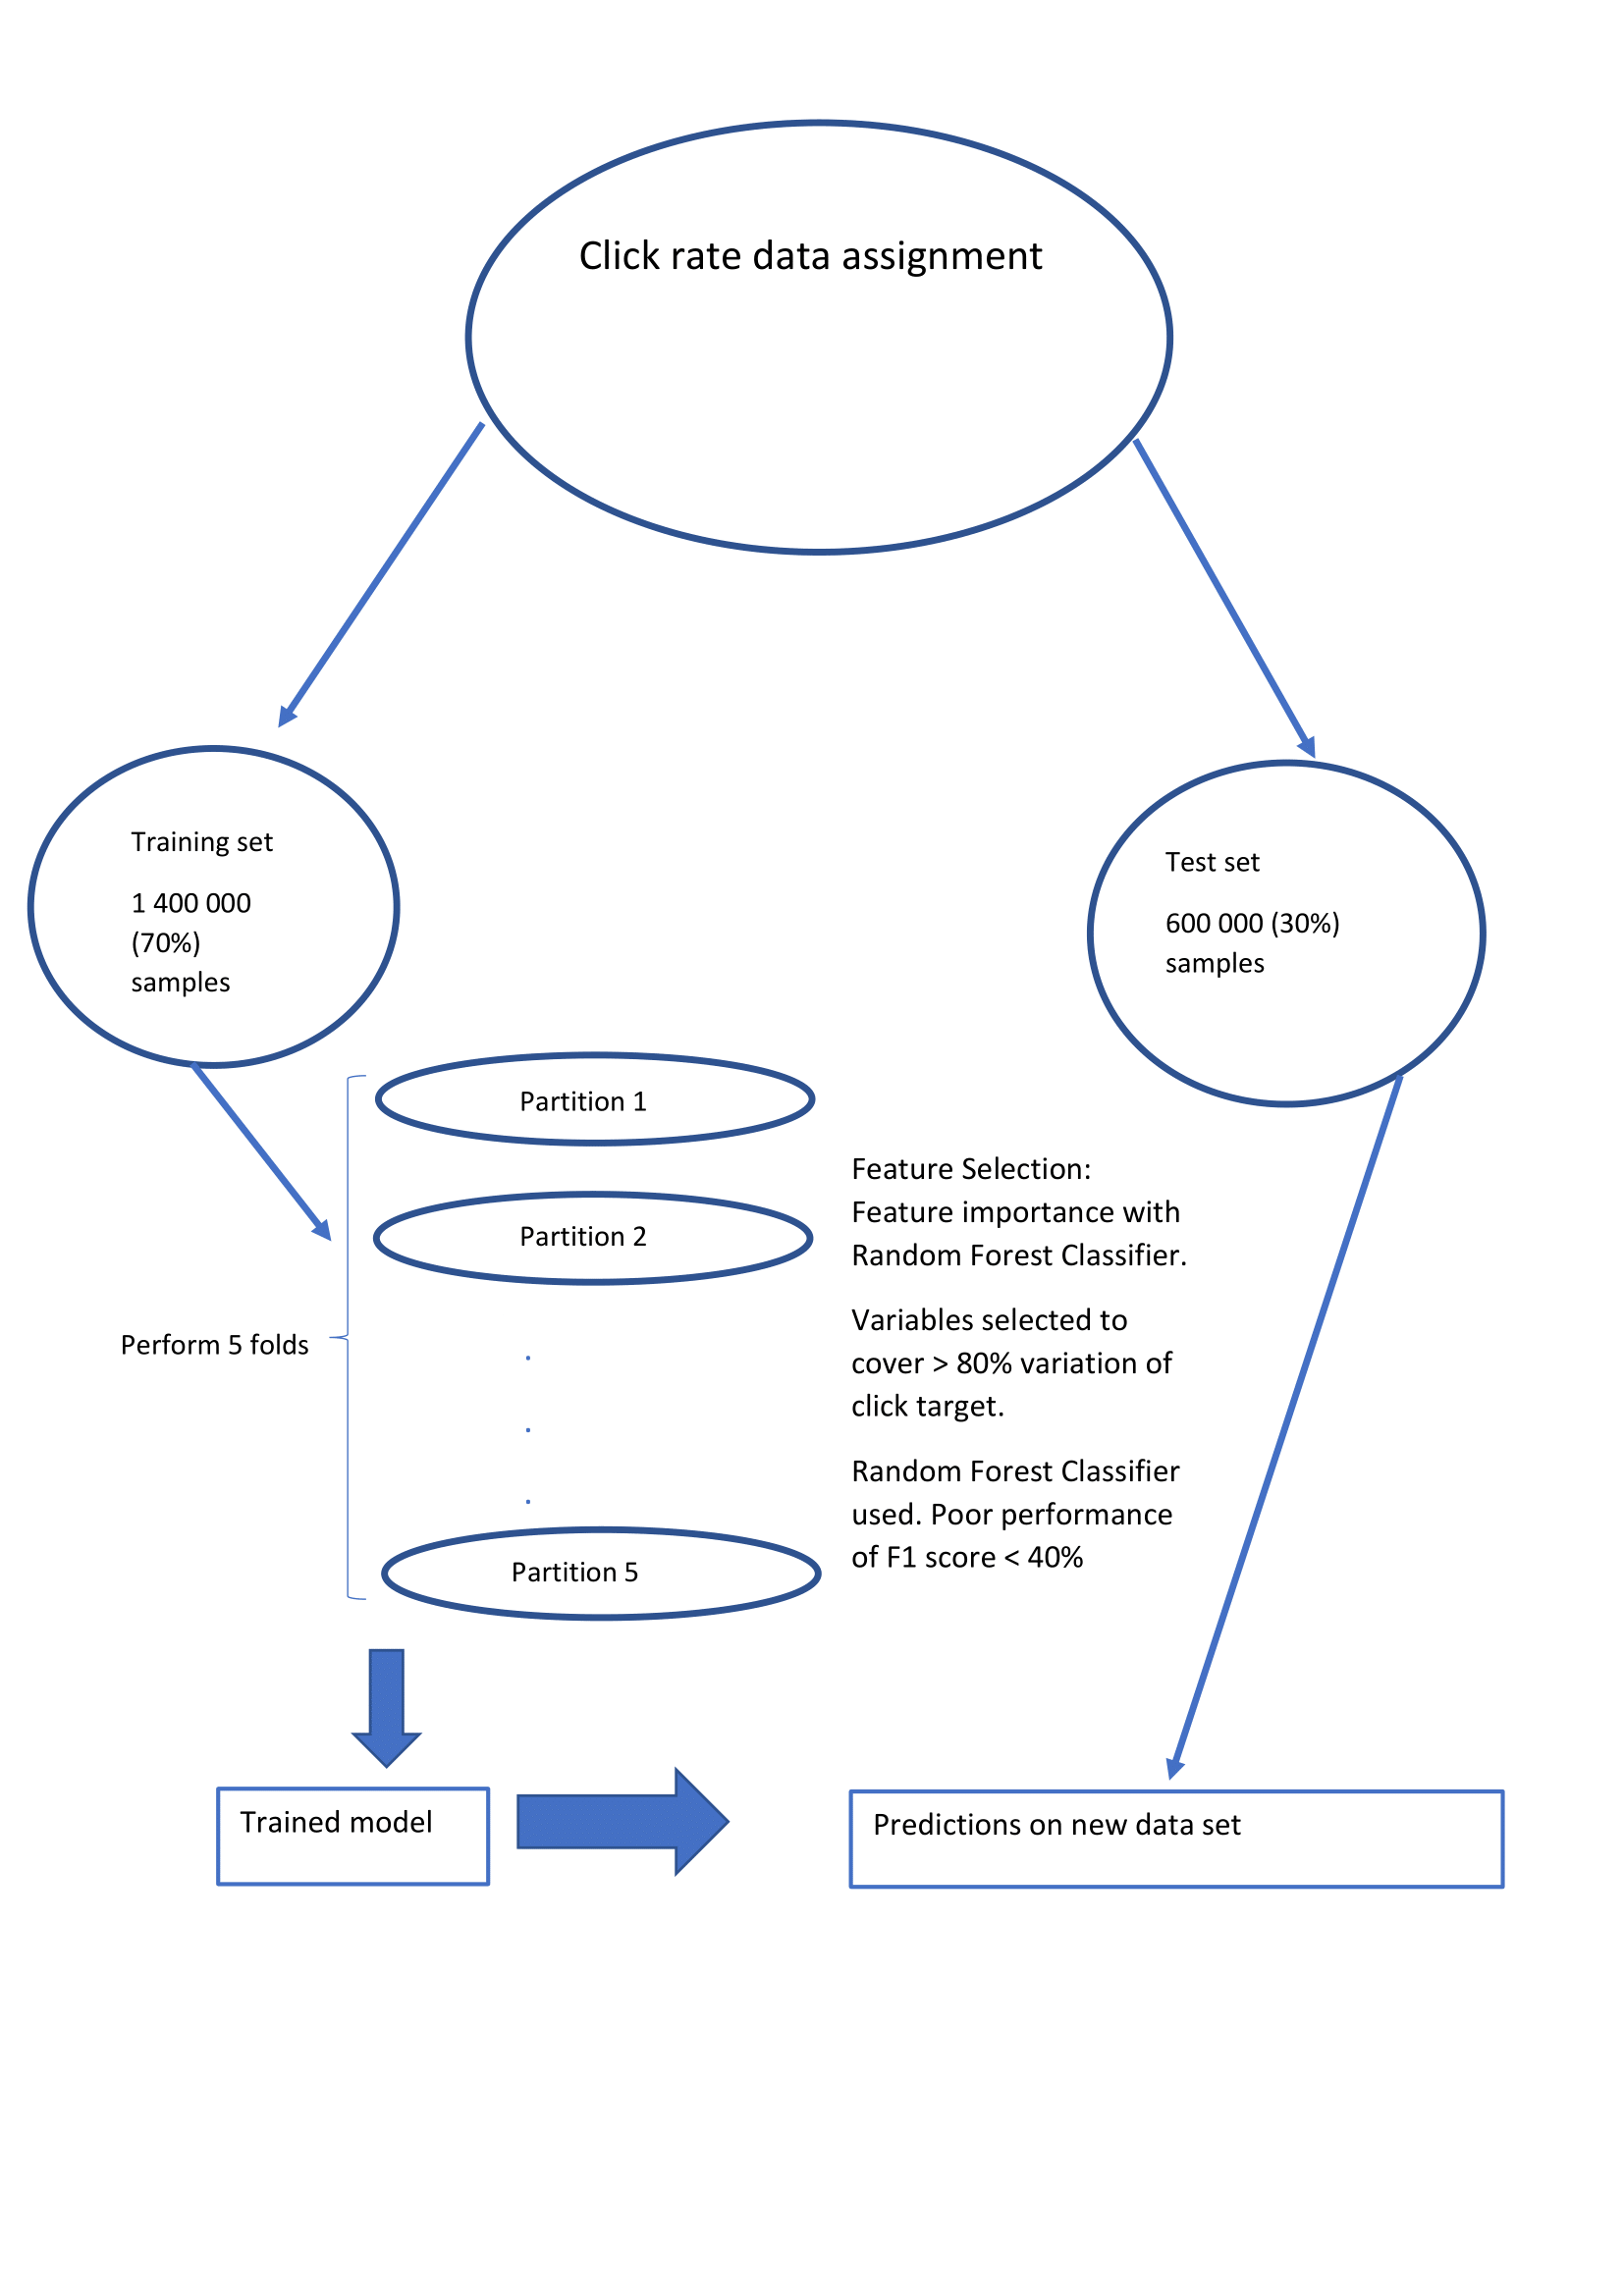

In [1]:

from IPython.display import Image

fig = Image(filename='FlowChart4JupyterNb-1.png')
fig

In [2]:
data = pd.read_csv("train")

In [3]:
data.head()

,id,unix_timestamp,ui_component_position,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,f0,f1,f2,f3,f4,f5,f6,f7,f8,click
0,10000679056417042096,1413849600,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,...,1005,18993,320,50,2161,0,35,NaN,157,0
1,10010730108771379386,1413849600,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,1005,20634,320,50,2374,3,39,NaN,23,0
2,10017325201002992404,1413849600,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1005,15705,320,50,1722,0,35,NaN,79,1
3,10018897422996679694,1413849600,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,1005,20366,320,50,2333,0,39,NaN,157,0
4,10024660782388112342,1413849600,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,1005,17614,320,50,1993,2,1063,100083.0,33,1


| Field Name            | Description                                                   
|-----------------------|---------------------------------------------------------------
| id                    | listing Identifier for each listing advertisement             
| unix_timestamp        | time when click event occured.                                
| ui_component_position | Position on device where listing advertisement was displayed. 
| site_id               | partner sites where ad was shown.
| site_domain           | domain/country where partner site operates in.
| app_id                | special identifier for app used
| device_id             | special identifier for device used
| device_conn_type      | type of network connection used by device
| f0-f8                 | anonymized categorical variables
| click                 | Target variable (0/1). Where 1 - clicked, 0 - not clicked

### Check dimension of data, Nulls, and %target population.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999999 entries, 0 to 1999998
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     uint64 
 1   unix_timestamp         int64  
 2   ui_component_position  int64  
 3   site_id                object 
 4   site_domain            object 
 5   site_category          object 
 6   app_id                 object 
 7   app_domain             object 
 8   app_category           object 
 9   device_id              object 
 10  device_ip              object 
 11  device_model           object 
 12  device_type            int64  
 13  device_conn_type       int64  
 14  f0                     int64  
 15  f1                     int64  
 16  f2                     int64  
 17  f3                     int64  
 18  f4                     int64  
 19  f5                     int64  
 20  f6                     int64  
 21  f7                     float64
 22  f8                

In [5]:
data.shape

(1999999, 24)

In [6]:
data.isnull().sum()/len(data)

id                       0.000000
unix_timestamp           0.000000
ui_component_position    0.000000
site_id                  0.000000
site_domain              0.000000
site_category            0.000000
app_id                   0.000000
app_domain               0.000000
app_category             0.000000
device_id                0.000000
device_ip                0.000000
device_model             0.000000
device_type              0.000000
device_conn_type         0.000000
f0                       0.000000
f1                       0.000000
f2                       0.000000
f3                       0.000000
f4                       0.000000
f5                       0.000000
f6                       0.000000
f7                       0.468622
f8                       0.000000
click                    0.000000
dtype: float64

In [7]:
data["click"].value_counts()/len(data)

0    0.830121
1    0.169879
Name: click, dtype: float64

In [8]:
### Check if Nulls for variables add value
tmp = data[["id","f7", "click"]].copy()
tmp["f7nullflag"] = np.where(tmp["f7"].isnull(), 1, 0)
tmp["f7nullflag"].value_counts()

tmp = tmp.groupby("f7nullflag").agg({"id": "count", "click": 'sum'})
tmp['click_rate'] = tmp["click"]/tmp["id"]
###check
print("Total {}".format(len(data) - tmp["id"].sum() == 0))
tmp

Total True


,id,click,click_rate
f7nullflag,,,
0,1062756,158628,0.149261
1,937243,181129,0.193257


### The missing values for f7 has a higher than click rate the overall average, hence it may prove worthwhile including it.

In [7]:
##### Need to replace the nan with 99999
# print(data["f7"].unique())
# print(data["f7"].value_counts())
# print("")
# data["f7"].isnull().sum()
data["f7"] = np.where(data["f7"].isnull(), 99999, data["f7"]) ###937243 records

### check
# len(data[data["f7"] == 99999])
ls_fx = ["f"+str(i) for i in np.arange(9)]

### force f variables to object type    
for k in ls_fx:
    data[k] = data[k].astype(str)
    

In [4]:
### function to change unix timestamp into datetime
def unix2datetime(x):
    timestamp = datetime.datetime.fromtimestamp(x)
    date_time_str = timestamp.strftime('%Y-%m-%d %H:%M:%S')
    return datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S') #timestamp.strftime('%Y-%m-%d %H:%M:%S')

In [5]:

data["timeofclick"] = data["unix_timestamp"].apply(lambda x: unix2datetime(x))


In [6]:
data["weekday"] = data["timeofclick"].apply(lambda x: x.weekday())
data["hour"] = data["timeofclick"].apply(lambda x: x.hour)

### Make into str variable
data["weekday"] = data["weekday"].astype(str)
data["hour"] = data["hour"].astype(str)

In [8]:
list(data)

['id',
 'unix_timestamp',
 'ui_component_position',
 'site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'device_type',
 'device_conn_type',
 'f0',
 'f1',
 'f2',
 'f3',
 'f4',
 'f5',
 'f6',
 'f7',
 'f8',
 'click',
 'timeofclick',
 'weekday',
 'hour']

### Split into train/test

In [9]:
# Splitting the dataset into the Training set and Test set
X = data.drop("click", axis = 1)
y = data["click"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### Select k best variables using chi square

In [11]:
# kval = 5 ### slect 5 best features
# # k = 4 tells four top features to be selected
# # Score function Chi2 tells the feature to be selected using Chi Square
# test = SelectKBest(score_func=chi2, k=kval)
# fit = test.fit(X_train, y_train)
# fit.scores_

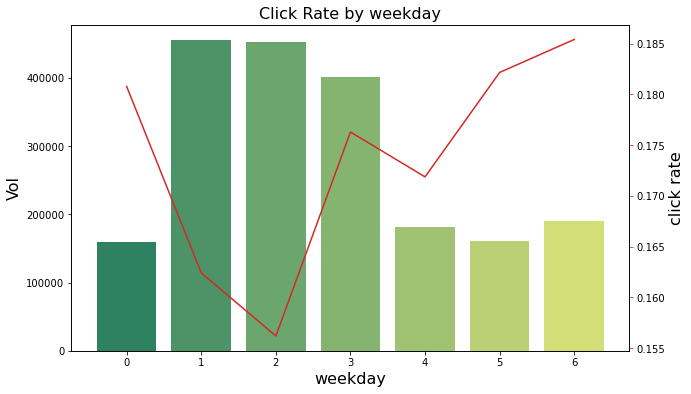

Total True


,Vol,click_vol,click_rate
weekday,,,
0,159397,28817,0.180788
1,454951,73885,0.162402
2,452517,70675,0.156182
3,400414,70591,0.176295
4,181921,31267,0.171871
5,160906,29312,0.182168
6,189893,35210,0.185420


In [12]:
### Explore distinction of target for chosen variable
### Evidence to show that weekends are highest click rates (5-6)
var = "weekday" ### "hour"
tmp = data.groupby(var).agg({"id": "count", "click": 'sum'})
tmp['click_rate'] = tmp["click"]/tmp["id"]
tmp = tmp.rename(columns={"id": "Vol", "click": "click_vol"})

#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
#bar plot creation
ttle = 'Click Rate by '+var
ax1.set_title(ttle, fontsize=16)

x_ax = [str(i) for i in tmp.index.values]
ax1 = sns.barplot(x = x_ax #x_val 
                  , y = 'Vol', data = tmp, palette='summer')

    
ax1.tick_params(axis='y')
ax1.set_xlabel(var, fontsize=16)
ax1.set_ylabel('Vol', fontsize=16)

#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('click rate', fontsize=16)
ax2 = sns.lineplot(x = x_ax #x_val 
                   , y='click_rate', data = tmp, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.show()


###check
print("Total {}".format(len(data) - tmp["Vol"].sum() == 0))
tmp

### ui_component_position

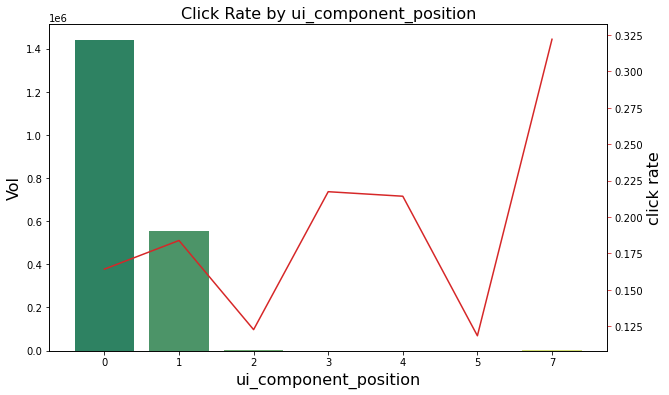

Total True


,Vol,click_vol,click_rate,vol%
ui_component_position,,,,
0,1440598,236625,0.164255,0.720299
1,555838,102223,0.183908,0.277919
2,660,81,0.122727,0.000330
3,92,20,0.217391,0.000046
4,392,84,0.214286,0.000196
5,270,32,0.118519,0.000135
7,2149,692,0.322010,0.001075


In [13]:

### Explore distinction of target for chosen variable

var = "ui_component_position" ### "hour"
tmp = data.groupby(var).agg({"id": "count", "click": 'sum'})
tmp['click_rate'] = tmp["click"]/tmp["id"]
tmp = tmp.rename(columns={"id": "Vol", "click": "click_vol"})
tmp["vol%"] = tmp["Vol"]/tmp["Vol"].sum()

#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
#bar plot creation
ttle = 'Click Rate by '+var
ax1.set_title(ttle, fontsize=16)

x_ax = [str(i) for i in tmp.index.values]
ax1 = sns.barplot(x = x_ax #x_val 
                  , y = 'Vol', data = tmp, palette='summer')

    
ax1.tick_params(axis='y')
ax1.set_xlabel(var, fontsize=16)
ax1.set_ylabel('Vol', fontsize=16)

#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('click rate', fontsize=16)
ax2 = sns.lineplot(x = x_ax #x_val 
                   , y='click_rate', data = tmp, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.show()


###check
print("Total {}".format(len(data) - tmp["Vol"].sum() == 0))
tmp

### site_id. There are over 3 000 levels. Taking those sites with 1% vol or more

In [16]:
### Explore distinction of target for chosen variable

var = "site_id" 
tmp = data.groupby(var).agg({"id": "count", "click": 'sum'})
tmp['click_rate'] = tmp["click"]/tmp["id"]
tmp = tmp.rename(columns={"id": "Vol", "click": "click_vol"})
tmp["vol%"] = tmp["Vol"]/tmp["Vol"].sum()

tmp = tmp.sort_values("Vol", ascending=False)
tmp2 = tmp[tmp["vol%"] >= 0.01].copy()
###check
print("Total {}".format(len(data) - tmp["Vol"].sum() == 0))

### Store the category levels to file
tmp2['Var'] = tmp2.index
tmp2.to_csv(var + '.csv', index=False, header=True, columns=['Var', 'click_rate'])
tmp2.head(10)

Total True


,Vol,click_vol,click_rate,vol%,Var
site_id,,,,,
85f751fd,722716,85729,0.118621,0.361358,85f751fd
1fbe01fe,320736,65846,0.205297,0.160368,1fbe01fe
e151e245,130812,38632,0.295325,0.065406,e151e245
d9750ee7,47715,13270,0.278110,0.023858,d9750ee7
5b08c53b,45248,21248,0.469590,0.022624,5b08c53b
5b4d2eda,38134,4960,0.130068,0.019067,5b4d2eda
856e6d3f,37662,1635,0.043412,0.018831,856e6d3f
a7853007,22856,2423,0.106012,0.011428,a7853007


### site_domain. There are over 3 000 levels. Taking those sites with 1% vol or more

In [17]:
### Explore distinction of target for chosen variable
var = "site_domain" 
tmp = data.groupby(var).agg({"id": "count", "click": 'sum'})
tmp['click_rate'] = tmp["click"]/tmp["id"]
tmp = tmp.rename(columns={"id": "Vol", "click": "click_vol"})
tmp["vol%"] = tmp["Vol"]/tmp["Vol"].sum()

tmp = tmp.sort_values("Vol", ascending=False)
tmp2 = tmp[tmp["vol%"] >= 0.01].copy()
###check
print("Total {}".format(len(data) - tmp["Vol"].sum() == 0))

### Store the category levels to file
tmp2['Var'] = tmp2.index
tmp2.to_csv(var + '.csv', index=False, header=True, columns=['Var', 'click_rate'])
tmp2.head(10)

Total True


,Vol,click_vol,click_rate,vol%,Var
site_domain,,,,,
c4e18dd6,748888,91827,0.122618,0.374444,c4e18dd6
f3845767,320736,65846,0.205297,0.160368,f3845767
7e091613,164808,42491,0.257821,0.082404,7e091613
7687a86e,63959,29470,0.460764,0.031980,7687a86e
98572c79,49383,13430,0.271956,0.024692,98572c79
16a36ef3,42356,6040,0.142601,0.021178,16a36ef3
58a89a43,37662,1635,0.043412,0.018831,58a89a43


### site_category. 21 levels

In [25]:

### Explore distinction of target for chosen variable
var = "site_category" 
tmp = data.groupby(var).agg({"id": "count", "click": 'sum'})
tmp['click_rate'] = tmp["click"]/tmp["id"]
tmp = tmp.rename(columns={"id": "Vol", "click": "click_vol"})
tmp["vol%"] = tmp["Vol"]/tmp["Vol"].sum()

tmp = tmp.sort_values("Vol", ascending=False)
### seems only these levels have significant volume
tmp2 = tmp.iloc[0:12, :].copy() 

# ### Store the category levels to file
tmp2['Var'] = tmp2.index
tmp2.to_csv(var + '.csv', index=False, header=True, columns=['Var', 'click_rate'])
tmp2

,Vol,click_vol,click_rate,vol%,Var
site_category,,,,,
50e219e0,819116,105295,0.128547,0.409558,50e219e0
f028772b,625633,112577,0.179941,0.312817,f028772b
28905ebd,364460,75678,0.207644,0.182230,28905ebd
3e814130,151054,42811,0.283415,0.075527,3e814130
f66779e6,12325,493,0.040000,0.006163,f66779e6
75fa27f6,8061,907,0.112517,0.004031,75fa27f6
335d28a8,6739,636,0.094376,0.003370,335d28a8
76b2941d,5155,163,0.031620,0.002578,76b2941d
c0dd3be3,2006,236,0.117647,0.001003,c0dd3be3


### app_id. There are over 3000 levels

In [33]:

### Explore distinction of target for chosen variable
var = "app_id" 
tmp = data.groupby(var).agg({"id": "count", "click": 'sum'})
tmp['click_rate'] = tmp["click"]/tmp["id"]
tmp = tmp.rename(columns={"id": "Vol", "click": "click_vol"})
tmp["vol%"] = tmp["Vol"]/tmp["Vol"].sum()

tmp = tmp.sort_values("Vol", ascending=False)
tmp2 = tmp[tmp["vol%"] >= 0.01].copy()
###check
print("Total {}".format(len(data) - tmp["Vol"].sum() == 0))

# ### Store the category levels to file
tmp2['Var'] = tmp2.index
tmp2.to_csv(var + '.csv', index=False, header=True, columns=['Var', 'click_rate'])
tmp2.head(25)

Total True


,Vol,click_vol,click_rate,vol%,Var
app_id,,,,,
ecad2386,1277283,254028,0.198882,0.638642,ecad2386
92f5800b,77181,1487,0.019266,0.038591,92f5800b
e2fcccd2,56102,10847,0.193344,0.028051,e2fcccd2
febd1138,37416,1796,0.048001,0.018708,febd1138
9c13b419,37292,11409,0.305937,0.018646,9c13b419
7358e05e,30354,5786,0.190617,0.015177,7358e05e
a5184c22,24041,5865,0.243958,0.012021,a5184c22
d36838b1,22804,1658,0.072707,0.011402,d36838b1
685d1c4c,20205,1485,0.073497,0.010103,685d1c4c


### app_domain. There are over 250 levels

In [38]:

### Explore distinction of target for chosen variable
var = "app_domain" 
tmp = data.groupby(var).agg({"id": "count", "click": 'sum'})
tmp['click_rate'] = tmp["click"]/tmp["id"]
tmp = tmp.rename(columns={"id": "Vol", "click": "click_vol"})
tmp["vol%"] = tmp["Vol"]/tmp["Vol"].sum()

tmp = tmp.sort_values("Vol", ascending=False)
tmp2 = tmp[tmp["vol%"] >= 0.005].copy()
###check
print("Total {}".format(len(data) - tmp["Vol"].sum() == 0))

# ### Store the category levels to file
tmp2['Var'] = tmp2.index
tmp2.to_csv(var + '.csv', index=False, header=True, columns=['Var', 'click_rate'])
tmp2.head(25)

Total True


,Vol,click_vol,click_rate,vol%,Var
app_domain,,,,,
7801e8d9,1346893,262805,0.195119,0.673447,7801e8d9
2347f47a,259372,35709,0.137675,0.129686,2347f47a
ae637522,93280,2229,0.023896,0.046640,ae637522
5c5a694b,56108,10847,0.193324,0.028054,5c5a694b
82e27996,37418,1796,0.047998,0.018709,82e27996
d9b5648e,35160,3862,0.109841,0.017580,d9b5648e
0e8616ad,32960,2405,0.072967,0.016480,0e8616ad
b9528b13,31838,5858,0.183994,0.015919,b9528b13
b8d325c3,26144,5977,0.228618,0.013072,b8d325c3


### app_category. There are over 28 levels

In [45]:

### Explore distinction of target for chosen variable
var = "app_category" 
tmp = data.groupby(var).agg({"id": "count", "click": 'sum'})
tmp['click_rate'] = tmp["click"]/tmp["id"]
tmp = tmp.rename(columns={"id": "Vol", "click": "click_vol"})
tmp["vol%"] = tmp["Vol"]/tmp["Vol"].sum()

tmp = tmp.sort_values("Vol", ascending=False)
tmp2 = tmp[tmp["vol%"] >= 0.00004].copy()
###check
print("Total {}".format(len(data) - tmp["Vol"].sum() == 0))

# ### Store the category levels to file
tmp2['Var'] = tmp2.index
tmp2.to_csv(var + '.csv', index=False, header=True, columns=['Var', 'click_rate'])
tmp2

Total True


,Vol,click_vol,click_rate,vol%,Var
app_category,,,,,
07d7df22,1293980,258020,0.199400,0.646990,07d7df22
0f2161f8,473552,51135,0.107982,0.236776,0f2161f8
cef3e649,85298,8026,0.094094,0.042649,cef3e649
8ded1f7a,72748,6448,0.088635,0.036374,8ded1f7a
f95efa07,56324,13935,0.247408,0.028162,f95efa07
d1327cf5,6143,734,0.119486,0.003072,d1327cf5
09481d60,2830,434,0.153357,0.001415,09481d60
dc97ec06,2731,424,0.155254,0.001366,dc97ec06
75d80bbe,1928,184,0.095436,0.000964,75d80bbe


### device_id. There are over 270000 levels

In [48]:

### Explore distinction of target for chosen variable
var = "device_id" 
tmp = data.groupby(var).agg({"id": "count", "click": 'sum'})
tmp['click_rate'] = tmp["click"]/tmp["id"]
tmp = tmp.rename(columns={"id": "Vol", "click": "click_vol"})
tmp["vol%"] = tmp["Vol"]/tmp["Vol"].sum()

tmp = tmp.sort_values("Vol", ascending=False)
tmp2 = tmp[tmp["vol%"] >= 0.00004].copy()
###check
print("Total {}".format(len(data) - tmp["Vol"].sum() == 0))

# ### Store the category levels to file
tmp2['Var'] = tmp2.index
tmp2.to_csv(var + '.csv', index=False, header=True, columns=['Var', 'click_rate'])
tmp2

Total True


,Vol,click_vol,click_rate,vol%,Var
device_id,,,,,
a99f214a,1649314,287259,0.174169,0.824657,a99f214a
0f7c61dc,1046,792,0.757170,0.000523,0f7c61dc
c357dbff,1003,643,0.641077,0.000502,c357dbff
936e92fb,673,51,0.075780,0.000337,936e92fb
afeffc18,498,123,0.246988,0.000249,afeffc18
987552d1,225,0,0.000000,0.000113,987552d1
28dc8687,203,0,0.000000,0.000102,28dc8687
d857ffbb,198,38,0.191919,0.000099,d857ffbb
cef4c8cc,194,39,0.201031,0.000097,cef4c8cc


### device_ip. There are over 960 000 levels

In [57]:

### Explore distinction of target for chosen variable
var = "device_ip" 
tmp = data.groupby(var).agg({"id": "count", "click": 'sum'})
tmp['click_rate'] = tmp["click"]/tmp["id"]
tmp = tmp.rename(columns={"id": "Vol", "click": "click_vol"})
tmp["vol%"] = tmp["Vol"]/tmp["Vol"].sum()

tmp = tmp.sort_values("Vol", ascending=False)
tmp2 = tmp[tmp["vol%"] >= 0.001].copy()
###check
print("Total {}".format(len(data) - tmp["Vol"].sum() == 0))

# ### Store the category levels to file
tmp2['Var'] = tmp2.index
tmp2.to_csv(var + '.csv', index=False, header=True, columns=['Var', 'click_rate'])
print("levels {}".format(tmp2.shape[0]))
tmp2

Total True
levels 21


,Vol,click_vol,click_rate,vol%,Var
device_ip,,,,,
6b9769f2,10336,2264,0.219040,0.005168,6b9769f2
431b3174,6662,1273,0.191084,0.003331,431b3174
2f323f36,4397,431,0.098021,0.002199,2f323f36
af9205f9,4322,445,0.102962,0.002161,af9205f9
af62faf4,4310,416,0.096520,0.002155,af62faf4
285aa37d,4284,400,0.093371,0.002142,285aa37d
930ec31d,4237,431,0.101723,0.002119,930ec31d
009a7861,4184,400,0.095602,0.002092,009a7861
d90a7774,4123,384,0.093136,0.002062,d90a7774


### device_model. There are over 5000 levels

In [62]:

### Explore distinction of target for chosen variable
var = "device_model" 
tmp = data.groupby(var).agg({"id": "count", "click": 'sum'})
tmp['click_rate'] = tmp["click"]/tmp["id"]
tmp = tmp.rename(columns={"id": "Vol", "click": "click_vol"})
tmp["vol%"] = tmp["Vol"]/tmp["Vol"].sum()

tmp = tmp.sort_values("Vol", ascending=False)
tmp2 = tmp[(tmp["click_rate"] >= 0.1) & (tmp["vol%"] >= 0.01)].copy()
###check
print("Total {}".format(len(data) - tmp["Vol"].sum() == 0))

# ### Store the category levels to file
tmp2['Var'] = tmp2.index
tmp2.to_csv(var + '.csv', index=False, header=True, columns=['Var', 'click_rate'])
print("number of levels {}".format(tmp2.shape[0]))
tmp2

Total True
number of levels 13


,Vol,click_vol,click_rate,vol%,Var
device_model,,,,,
8a4875bd,121347,16821,0.138619,0.060674,8a4875bd
1f0bc64f,70211,15710,0.223754,0.035106,1f0bc64f
d787e91b,69765,15535,0.222676,0.034883,d787e91b
76dc4769,38249,7321,0.191404,0.019125,76dc4769
be6db1d7,36425,6927,0.190172,0.018213,be6db1d7
a0f5f879,32221,5424,0.168337,0.016111,a0f5f879
4ea23a13,31883,6697,0.210049,0.015942,4ea23a13
7abbbd5c,31290,5437,0.173762,0.015645,7abbbd5c
ecb851b2,30285,5446,0.179825,0.015143,ecb851b2


### device_type. 

In [66]:
data["device_type"] = data["device_type"].astype(str)
data["device_type"].value_counts()

1    1844917
0     110406
4      38417
5       6258
2          1
Name: device_type, dtype: int64

### device_conn_type

In [69]:
data["device_conn_type"] = data["device_conn_type"].astype(str)
data["device_conn_type"].value_counts()

0    1725176
2     164540
3     108168
5       2115
Name: device_conn_type, dtype: int64

### f variables

In [114]:

### Explore distinction of target for chosen variable
var = "f5" 
tmp = data.groupby(var).agg({"id": "count", "click": 'sum'})
tmp['click_rate'] = tmp["click"]/tmp["id"]
tmp = tmp.rename(columns={"id": "Vol", "click": "click_vol"})
tmp["vol%"] = tmp["Vol"]/tmp["Vol"].sum()

tmp = tmp.sort_values("Vol", ascending=False)
tmp2 = tmp.copy() #tmp[(tmp["click_rate"] >= 0.1) & (tmp["vol%"] >= 0.01)].copy()
###check
print("Total {}".format(len(data) - tmp["Vol"].sum() == 0))

# ### Store the category levels to file
tmp2['Var'] = tmp2.index
### write to csv
tmp2.to_csv(var + '.csv', index=False, header=True, columns=['Var', 'click_rate'])
print("number of levels {}".format(tmp2.shape[0]))
tmp2


Total True
number of levels 4


,Vol,click_vol,click_rate,vol%,Var
f5,,,,,
0,836865,132145,0.157905,0.418433,0
3,674850,98915,0.146573,0.337425,3
2,353047,104078,0.294799,0.176524,2
1,135237,4619,0.034155,0.067619,1


### code only f1, f4, f6, f7, f8

In [ ]:

def recode_func(x, lst):
    res = 'Other'
    if (x in lst):
        res = x
    return res


### f variables. Code only f1, f4, f6, f7, f8

In [ ]:
data["f7"] = np.where(data["f7"].isnull(), 99999, data["f7"])

ls_fx = ["f"+str(i) for i in np.arange(9)]
    
### force f variables to object type    
for k in ls_fx:
    data[k] = data[k].astype(str)

In [ ]:
var = ['site_id', 'site_domain', 'site_category', 'app_id'
       , 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_conn_type'
      , 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']

for i in var:
    data[i] = data[i].replace(r'^\s*$', 'Other', regex=True) ###replace invalids with 'other'
    print('filename {}'.format(i+'.csv'))
    tmp = pd.read_csv(i+'.csv') ###read in the lu table
    data[i] = data[i].apply( lambda x: recode_func(x, tmp['Var'].values) ) ###recode the labels
    del tmp

categorical_features = var + ['ui_component_position', 'weekday', 'hour', 'device_type']    
for i in categorical_features:
    data[i] = data[i].astype(str)
    
### Format of the dump below is (variable_to_save, file_to_save_to)
categorical_filename = "NB304916cat_features_v00.p"
pickle.dump(categorical_features, open(categorical_filename, "wb" ))

In [ ]:
X = data[categorical_features]
y = data['click']

### One hot encoding

In [ ]:
one_hot = ce.OneHotEncoder(cols = categorical_features, handle_unknown='impute', use_cat_names=True)
one_hot = one_hot.fit(X)

pickle.dump(one_hot, open("NB304916oheNOPCA_v01.p", "wb" ))

X = one_hot.transform(X)

### Split into train/test

In [ ]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### Use Decision Tree for feature selection

In [ ]:
X_featscale = X_train

feature_importances = pd.DataFrame(RFclassifier.feature_importances_,
                                   index = X_featscale.iloc[:, :].columns, #don't want the last Target column
                                   columns=['importance']).sort_values('importance',ascending=False)


# feature_importances = pd.DataFrame(DTree.feature_importances_,
#                                    index = X_train.iloc[:, :].columns, #don't want the last Target column
#                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances['Cumul_Imp'] = feature_importances.cumsum().iloc[:,:]
###If you want to see only those that explain a % of variation
pct_var = 1.
feature_importances= feature_importances[(feature_importances['Cumul_Imp'] <= pct_var)]

In [ ]:
### Visualise

cols = feature_importances.index 
y_pos = np.arange(len(cols))
performance = feature_importances.importance

df2plot = pd.DataFrame(data = performance,
                      index = feature_importances.index)
df2plot['Variable'] = feature_importances.index
print(df2plot)

f, ax = plt.subplots(figsize=(6, 5))

sns.barplot(x="importance", y="Variable", data=df2plot,
            label="Variable Ranking", color="b")

ax.set(xlim=(0, 1), ylabel="",
       xlabel="importance")

for p in ax.patches:
    width = p.get_width()
    ax.text(width+0.05,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")